In [1]:
import sqlite3
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [18]:
RT_LIMIT_LOWER = 4340  # RT range in the database
RT_LIMIT_UPPER = 4580
RT_BASE_PEAK_WIDTH_SECS = 30.0  # assumption about base peak width in RT
RT_FRAGMENT_EVENT_DELTA_SECS = 3.5  # use this window for constraining RT to focus on the fragmentation event
MS1_CE = 10

In [19]:
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}-denoised".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
BASE_MAXQUANT_TXT_DIR = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt'
ALLPEPTIDES_FILENAME = '{}/allPeptides.txt'.format(BASE_MAXQUANT_TXT_DIR)
PASEF_MSMS_SCANS_FILENAME = '{}/pasefMsmsScans.txt'.format(BASE_MAXQUANT_TXT_DIR)

# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'

CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [20]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-4340-4580-denoised/HeLa_20KInt.sqlite'

In [21]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
ms2_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy <> {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
db_conn.close()

In [22]:
ms1_frame_properties_df.head()

,frame_id,retention_time_secs
0,40411,4340.340330
1,40422,4341.521415
2,40433,4342.702923
3,40444,4343.883324
4,40455,4345.067491


In [23]:
ms2_frame_properties_df.head()

,frame_id,retention_time_secs
0,40408,4340.019894
1,40409,4340.127084
2,40410,4340.233855
3,40412,4340.446655
4,40413,4340.554812


In [24]:
ms1_frame_delay = ms1_frame_properties_df.iloc[1].retention_time_secs - ms1_frame_properties_df.iloc[0].retention_time_secs
ms1_frame_delay

1.1810854877303427

In [25]:
len(ms1_frame_properties_df)

203

In [26]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [27]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,CollisionEnergy,Precursor
0,3,507,532,742.744835,2.427448,36.96,1
1,3,549,574,709.235759,2.092358,36.96,2
2,3,602,627,594.235088,2.000000,36.96,3
3,3,643,668,503.527768,2.000000,36.96,4
4,3,684,709,552.063870,2.000000,31.92,5


In [28]:
# add-in the retention time for the isolation windows and filter out the window not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2) - 0.7
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2) + 0.7
isolation_window_df['wide_rt_lower'] = isolation_window_df.retention_time_secs - RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['wide_rt_upper'] = isolation_window_df.retention_time_secs + RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['fe_rt_lower'] = isolation_window_df.retention_time_secs - RT_FRAGMENT_EVENT_DELTA_SECS
isolation_window_df['fe_rt_upper'] = isolation_window_df.retention_time_secs + RT_FRAGMENT_EVENT_DELTA_SECS

In [29]:
# filter out isolation windows that don't fit in the database subset we have loaded
isolation_window_df = isolation_window_df[(isolation_window_df.wide_rt_lower >= RT_LIMIT_LOWER) & (isolation_window_df.wide_rt_upper <= RT_LIMIT_UPPER)]

In [30]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper,wide_rt_lower,wide_rt_upper,fe_rt_lower,fe_rt_upper
315657,40688,219,244,1106.675230,3.0,148941,4370.101926,1104.475230,1108.875230,4340.101926,4400.101926,4366.601926,4373.601926
315658,40688,287,312,987.488407,3.0,148938,4370.101926,985.288407,989.688407,4340.101926,4400.101926,4366.601926,4373.601926
315659,40688,344,369,922.491024,3.0,148930,4370.101926,920.291024,924.691024,4340.101926,4400.101926,4366.601926,4373.601926
315660,40688,386,411,884.941548,3.0,148942,4370.101926,882.741548,887.141548,4340.101926,4400.101926,4366.601926,4373.601926
315661,40688,434,459,876.400632,3.0,148943,4370.101926,874.200632,878.600632,4340.101926,4400.101926,4366.601926,4373.601926


### Select one of the isolation windows for analysis

In [31]:
print("There are {} precursor isolation windows.".format(len(isolation_window_df)))

There are 17860 precursor isolation windows.


In [32]:
# ISOLATION_WINDOW_IDX = 8089
# window_df = isolation_window_df.iloc[ISOLATION_WINDOW_IDX]

In [33]:
PRECURSOR_ID = 153421
window_df = isolation_window_df[isolation_window_df.Precursor == PRECURSOR_ID].iloc[0]

In [34]:
window_df

Frame                   41474.000000
ScanNumBegin              462.000000
ScanNumEnd                487.000000
IsolationMz               860.444362
IsolationWidth              3.000000
Precursor              153421.000000
retention_time_secs      4454.557286
mz_lower                  858.244362
mz_upper                  862.644362
wide_rt_lower            4424.557286
wide_rt_upper            4484.557286
fe_rt_lower              4451.057286
fe_rt_upper              4458.057286
Name: 324135, dtype: float64

In [35]:
window_mz_lower = window_df.mz_lower
window_mz_upper = window_df.mz_upper
scan_width = int(window_df.ScanNumEnd - window_df.ScanNumBegin)
wide_scan_lower = int(window_df.ScanNumBegin - scan_width)
wide_scan_upper = int(window_df.ScanNumEnd + scan_width)
fe_scan_lower = int(window_df.ScanNumBegin)
fe_scan_upper = int(window_df.ScanNumEnd)
wide_rt_lower = window_df.wide_rt_lower
wide_rt_upper = window_df.wide_rt_upper
fe_rt_lower = window_df.fe_rt_lower
fe_rt_upper = window_df.fe_rt_upper
precursor_id = int(window_df.Precursor)

In [36]:
# get the ms1 frame IDs
ms1_frame_ids = tuple(ms1_frame_properties_df.astype(int).values[:,0])


In [37]:
# load the cube's raw ms1 points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(window_mz_lower, window_mz_upper, wide_scan_lower, wide_scan_upper, wide_rt_lower, wide_rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [38]:
len(ms1_raw_points_df)

13336

In [39]:
ms1_raw_points_df.intensity.max()

1788

In [40]:
ms1_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
0,41203,858.410610,437,28,4425.463095
1,41203,858.881894,437,61,4425.463095
2,41203,859.385664,437,99,4425.463095
3,41203,859.898830,437,54,4425.463095
4,41203,860.384397,437,58,4425.463095


In [41]:
ms1_raw_points_df.describe()

,frame_id,mz,scan,intensity,retention_time_secs
count,13336.000000,13336.000000,13336.000000,13336.000000,13336.000000
mean,41456.343131,859.647011,459.934388,109.451860,4452.659558
std,121.385214,1.033862,17.687030,180.296047,13.026997
min,41203.000000,858.350554,437.000000,9.000000,4425.463095
25%,41379.000000,858.900379,445.000000,37.000000,4444.358407
50%,41467.000000,859.427267,456.000000,59.000000,4453.805803
75%,41522.000000,860.393648,471.000000,93.000000,4459.706028
max,41753.000000,862.476217,512.000000,1788.000000,4484.495019


In [42]:
# get the raw points constrained to the fragmentation event's RT
fe_raw_points_df = ms1_raw_points_df[(ms1_raw_points_df.retention_time_secs >= fe_rt_lower) & (ms1_raw_points_df.retention_time_secs <= fe_rt_upper)]

In [43]:
fe_raw_points_df.to_csv('/Users/darylwilding-mcbride/Downloads/fe_raw_points_ms1.csv')

In [44]:
MS1_MZ_BIN_WIDTH = 0.1

In [45]:
ms1_bins = np.arange(start=window_mz_lower, stop=window_mz_upper+MS1_MZ_BIN_WIDTH, step=MS1_MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [46]:
# adjust the bins to illustrate the peak splitting issue
# ms1_bins += 0.06

In [47]:
MZ_BIN_COUNT = len(ms1_bins)

In [48]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
ms1_mz_values_array = np.empty(MZ_BIN_COUNT, dtype=np.object)
for idx in range(MZ_BIN_COUNT):
    ms1_mz_values_array[idx] = []


In [49]:
%%time

# gather the m/z values into bins
for r in zip(fe_raw_points_df.mz, fe_raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= window_mz_lower) and (mz <= window_mz_upper): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, ms1_bins)) # in which bin should this mz go
        ms1_mz_values_array[mz_array_idx].append((mz, intensity))

CPU times: user 14.1 ms, sys: 2.84 ms, total: 17 ms
Wall time: 15 ms


In [50]:
import peakutils

In [51]:
%%time

# compute the intensity-weighted m/z centroid and the summed intensity of the bins
ms1_peaks = []
for bin_idx in range(MZ_BIN_COUNT):
    if len(ms1_mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in ms1_mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in ms1_mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        ms1_peaks.append((mz_centroid,summed_intensity))

CPU times: user 3.66 ms, sys: 1.2 ms, total: 4.85 ms
Wall time: 3.99 ms


In [52]:
ms1_peaks

[(858.4183662399726, 9157),
 (858.4648362183859, 13978),
 (858.7342638713561, 507),
 (858.7873276735494, 11134),
 (858.9359173297187, 268289),
 (858.9497802205657, 9338),
 (859.1245770969986, 7283),
 (859.1794667234411, 6523),
 (859.2787483097467, 574),
 (859.4364314387802, 223956),
 (859.4480388241063, 30504),
 (859.6260753528118, 496),
 (859.6783692241803, 3523),
 (859.8002561384817, 1703),
 (859.9356916579763, 94177),
 (859.9461141889395, 41067),
 (860.4321745299839, 28941),
 (860.4474659675384, 24082),
 (860.7405677886669, 89),
 (860.757036224673, 2388),
 (860.9352023500139, 11078),
 (860.9530934654725, 5359),
 (861.0887512192197, 1353),
 (861.4253009144168, 4720),
 (861.4526655904288, 1487),
 (861.9350534441518, 2530),
 (861.9507504952408, 1279),
 (862.433912659556, 2398),
 (862.4513218681186, 1056)]

In [53]:
ms1_peaks_df = pd.DataFrame(ms1_peaks, columns=['mz_centroid','summed_intensity'])

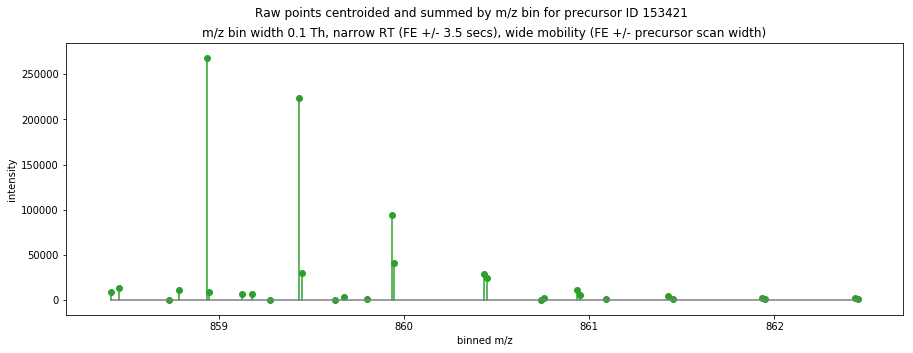

In [54]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(ms1_peaks_df.mz_centroid, ms1_peaks_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

Trying very small bins, then intensity descent

In [274]:
MS1_MZ_BIN_WIDTH = 1e-5

In [56]:
ms1_bins = np.arange(start=window_mz_lower, stop=window_mz_upper+MS1_MZ_BIN_WIDTH, step=MS1_MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [57]:
# adjust the bins to illustrate the peak splitting issue
# ms1_bins += 0.06

In [58]:
MZ_BIN_COUNT = len(ms1_bins)

In [59]:
MZ_BIN_COUNT

440002

In [60]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
ms1_mz_values_array = np.empty(MZ_BIN_COUNT, dtype=np.object)
for idx in range(MZ_BIN_COUNT):
    ms1_mz_values_array[idx] = []


In [61]:
%%time

# gather the m/z values into bins
for r in zip(fe_raw_points_df.mz, fe_raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= window_mz_lower) and (mz <= window_mz_upper): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, ms1_bins)) # in which bin should this mz go
        ms1_mz_values_array[mz_array_idx].append((mz, intensity))

CPU times: user 1.42 s, sys: 8.31 ms, total: 1.43 s
Wall time: 1.45 s


In [62]:
import peakutils

In [63]:
%%time

# compute the intensity-weighted m/z centroid and the summed intensity of the bins
binned_ms1_l = []
for bin_idx in range(MZ_BIN_COUNT):
    if len(ms1_mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in ms1_mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in ms1_mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        binned_ms1_l.append((mz_centroid,summed_intensity))

CPU times: user 129 ms, sys: 5.64 ms, total: 134 ms
Wall time: 131 ms


In [64]:
binned_ms1_df = pd.DataFrame(binned_ms1_l, columns=['mz_centroid','summed_intensity'])

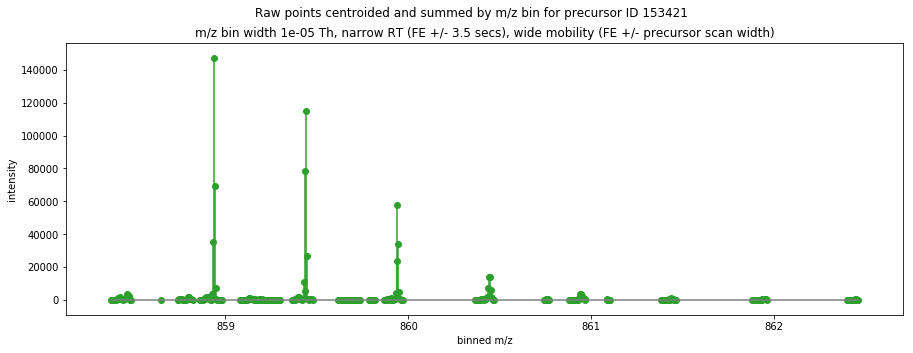

In [65]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(binned_ms1_df.mz_centroid, binned_ms1_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

Zooming in on a peak region

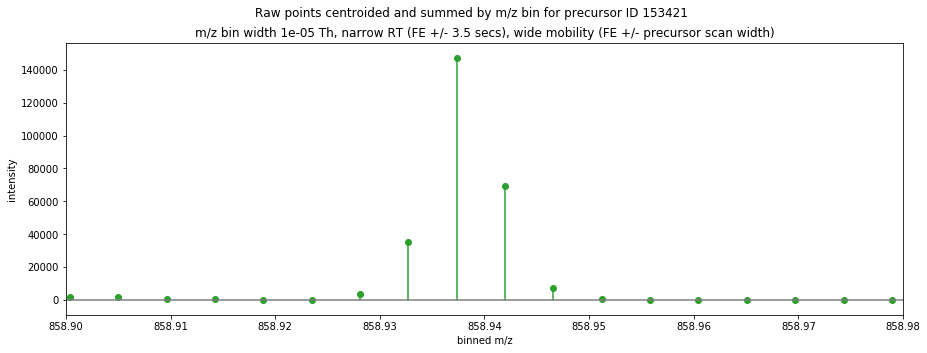

In [66]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(binned_ms1_df.mz_centroid, binned_ms1_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim([858.9,858.98])
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

In [67]:
raw_scratch_df = binned_ms1_df.copy() # take a copy because we're going to delete stuff

In [68]:
len(raw_scratch_df)

301

In [69]:
MZ_DELTA = 0.01

In [70]:
ms1_peaks_l = []
while len(raw_scratch_df) > 0:
    # find the most intense point
    peak_df = raw_scratch_df.loc[raw_scratch_df.summed_intensity.idxmax()]
    peak_mz = peak_df.mz_centroid
    peak_mz_lower = peak_mz - MZ_DELTA
    peak_mz_upper = peak_mz + MZ_DELTA

    # get all the raw points within this m/z region
    peak_raw_points_df = raw_scratch_df[(raw_scratch_df.mz_centroid >= peak_mz_lower) & (raw_scratch_df.mz_centroid <= peak_mz_upper)]
    mz_centroid = peakutils.centroid(peak_raw_points_df.mz_centroid, peak_raw_points_df.summed_intensity)
    summed_intensity = peak_raw_points_df.summed_intensity.sum()
    ms1_peaks_l.append((mz_centroid, summed_intensity))

    # remove the raw points assigned to this peak
    raw_scratch_df = raw_scratch_df[~raw_scratch_df.isin(peak_raw_points_df)].dropna(how = 'all')

In [71]:
ms1_peaks_df = pd.DataFrame(ms1_peaks_l, columns=['mz','intensity'])

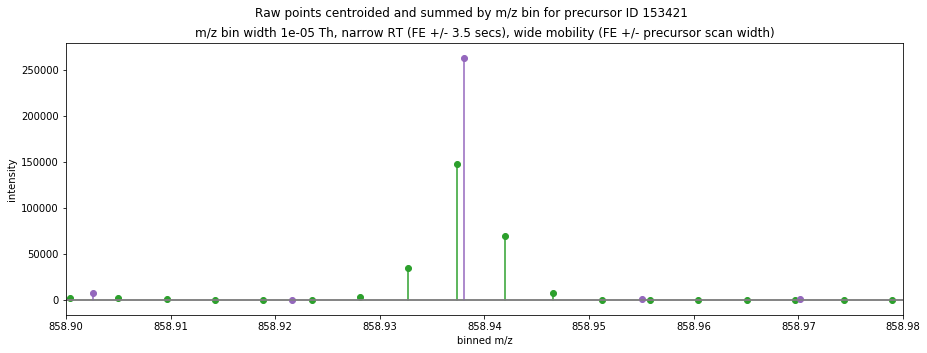

In [72]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(binned_ms1_df.mz_centroid, binned_ms1_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
markerline, stemlines, baseline = ax.stem(ms1_peaks_df.mz, ms1_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[4])
plt.setp(stemlines, 'color', colors[4])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim([858.9,858.98])
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

In [73]:
len(ms1_peaks_df)

91

### Deconvolute the raw (bin-summed, centroided) peaks to find monoisotopic peaks

In [74]:
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.


In [75]:
from ms_deisotope import deconvolute_peaks, averagine, scoring

In [76]:
%%time

# see https://github.com/mobiusklein/ms_deisotope/blob/ee4b083ad7ab5f77722860ce2d6fdb751886271e/ms_deisotope/deconvolution/api.py#L17
deconvoluted_peaks, _priority_targets = deconvolute_peaks(ms1_peaks_l, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

CPU times: user 256 ms, sys: 6.17 ms, total: 262 ms
Wall time: 266 ms


In [131]:
peaks_l = []
for peak in deconvoluted_peaks:
    # discard a monoisotopic peak that has a second isotope with intensity of 1 (rubbish value)
    if ((len(peak.envelope) > 1) and (peak.envelope[1][1] > 1)):
        peaks_l.append((peak.mz, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise, peak.envelope))
        print("{}\n".format(peak))

deconvoluted_peaks_df = pd.DataFrame(peaks_l, columns=['mz','neutral_mass','intensity','score','SN','envelope'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
deconvoluted_peaks_df['m_plus_h'] = deconvoluted_peaks_df.neutral_mass + PROTON_MASS


DeconvolutedPeak(a_to_a2_ratio=1.9308970182410141, area=8845.0, average_mass=1717.2576353965273, charge=2, chosen_for_msms=False, envelope=[(858.8877, 2893.00), (859.3866, 3421.00), (859.8864, 1868.00), (860.3836, 663.00)], full_width_at_half_max=0.01, index=0|4, intensity=8845.0, most_abundant_mass=1716.758689704914, mz=858.884943900327, neutral_mass=1715.755334867114, score=151.62093104819013, signal_to_noise=2211.25)

DeconvolutedPeak(a_to_a2_ratio=1.9308970182410141, area=20125.0, average_mass=1717.2893115897689, charge=2, chosen_for_msms=False, envelope=[(858.9026, 7938.00), (859.4025, 7153.00), (859.9029, 3563.00), (860.3997, 1471.00)], full_width_at_half_max=0.01, index=1|5, intensity=20125.0, most_abundant_mass=1715.7906722266334, mz=858.9008362629999, neutral_mass=1715.7871195924597, score=243.27637463042277, signal_to_noise=5031.25)

DeconvolutedPeak(a_to_a2_ratio=1.930897018241014, area=671128.0, average_mass=1717.3660155592238, charge=2, chosen_for_msms=False, envelope=[(85

In [132]:
deconvoluted_peaks_df

,mz,neutral_mass,intensity,score,SN,envelope,m_plus_h
0,858.884944,1715.755335,8845.000000,151.620931,2211.25,"((858.8877, 2893.00), (859.3866, 3421.00), (85...",1716.762635
1,858.900836,1715.787120,20125.000000,243.276375,5031.25,"((858.9026, 7938.00), (859.4025, 7153.00), (85...",1716.794420
2,858.938084,1715.861615,671128.000000,1478.708703,167782.00,"((858.9381, 263157.00), (859.4396, 237879.00),...",1716.868915
3,859.917519,1717.820485,4100.459317,84.070771,1314.75,"((859.9237, 1396.38), (860.4128, 1466.00), (86...",1718.827785
4,860.883419,1719.752285,738.000000,34.009529,246.00,"((860.8836, 345.00), (861.3851, 294.00), (861....",1720.759585
5,860.897498,1719.780444,1101.000000,40.542217,275.25,"((860.9014, 550.00), (861.3992, 398.00), (861....",1720.787744
6,860.941806,1719.869060,20642.000000,148.491047,5160.50,"((860.9418, 11839.00), (861.4359, 2983.00), (8...",1720.876360
7,858.088661,2571.244154,11852.000000,117.392595,2963.00,"((858.0887, 1.00), (858.4231, 5662.00), (858.7...",2572.251454
8,858.129642,2571.367096,26362.000000,230.024609,6590.50,"((858.1296, 1.00), (858.4638, 11862.00), (858....",2572.374396
9,860.088749,2577.244416,8110.000000,110.711473,2027.50,"((860.0887, 1.00), (860.4274, 3507.00), (860.7...",2578.251716


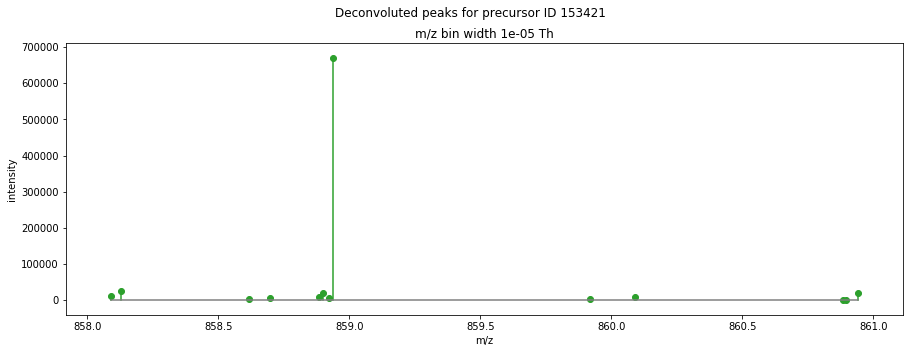

In [133]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(deconvoluted_peaks_df.mz, deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th'.format(MS1_MZ_BIN_WIDTH))
plt.show()

### For each monoisotopic peak found, find its apex in RT and mobility

In [134]:
# picking one of the monoisotopic peaks for analysis
DECONVOLUTED_PEAK_IDX = 2
feature_monoisotopic_mz = deconvoluted_peaks_df.iloc[DECONVOLUTED_PEAK_IDX].mz

In [135]:
feature_monoisotopic_mz

858.938084065498

In [136]:
second_peak_mz = deconvoluted_peaks_df.iloc[DECONVOLUTED_PEAK_IDX].envelope[1][0]

In [137]:
second_peak_mz

859.4396160724222

Get the raw points for the monoisotopic peak (constrained by the fragmentation event)

In [138]:
MZ_TOLERANCE_PPM = 20
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [139]:
monoisotopic_mz_ppm_tolerance = feature_monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100
monoisotopic_mz_lower = feature_monoisotopic_mz - monoisotopic_mz_ppm_tolerance
monoisotopic_mz_upper = feature_monoisotopic_mz + monoisotopic_mz_ppm_tolerance

In [140]:
monoisotopic_raw_points_df = fe_raw_points_df[(fe_raw_points_df.mz >= monoisotopic_mz_lower) & (fe_raw_points_df.mz <= monoisotopic_mz_upper)]

In [141]:
monoisotopic_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
5022,41445,858.932727,437,1037,4451.447545
5041,41445,858.932727,438,1443,4451.447545
5056,41445,858.937348,439,1495,4451.447545
5079,41445,858.932727,440,872,4451.447545
5098,41445,858.937348,441,1466,4451.447545


### Collapsing the monoisotopic's summed points onto the mobility dimension

In [142]:
scan_df = monoisotopic_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()

In [143]:
centroid_scan = peakutils.centroid(scan_df.scan, scan_df.intensity)

In [144]:
centroid_scan

462.40349209355173

In [145]:
feature_scan_centroid = centroid_scan
feature_scan_lower = window_df.ScanNumBegin
feature_scan_upper = window_df.ScanNumEnd

In [146]:
feature_scan_centroid, feature_scan_lower, feature_scan_upper

(462.40349209355173, 462.0, 487.0)

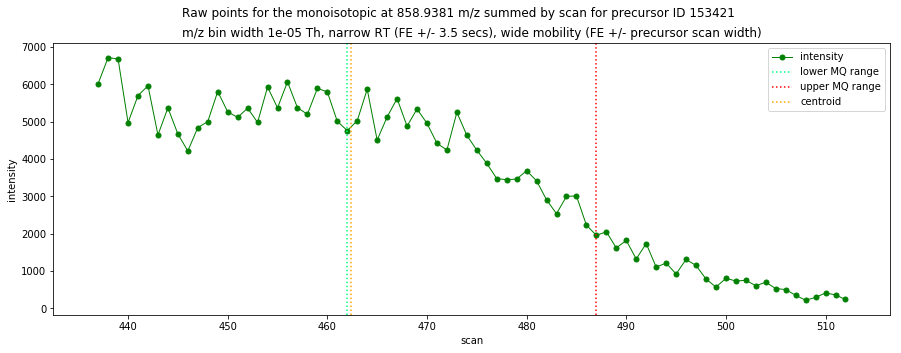

In [147]:
f, ax = plt.subplots()
ax.plot(scan_df.scan, scan_df.intensity, marker='o', color='green', linestyle='-', linewidth=1, ms=5)
plt.axvline(x=window_df.ScanNumBegin, linestyle=':', color='springgreen', label='lower MQ range')
plt.axvline(x=window_df.ScanNumEnd, linestyle=':', color='red', label='upper MQ range')
plt.axvline(x=centroid_scan, linestyle=':', color='orange', label='centroid')
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points for the monoisotopic at {:.4f} m/z summed by scan for precursor ID {}'.format(feature_monoisotopic_mz, precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.margins(0.06)
plt.show()

### In the RT dimension, look wider to find the apex of the peak closest to the fragmentation event

In [148]:
wide_rt_monoisotopic_raw_points_df = ms1_raw_points_df[(ms1_raw_points_df.mz >= monoisotopic_mz_lower) & (ms1_raw_points_df.mz <= monoisotopic_mz_upper)]

In [149]:
len(wide_rt_monoisotopic_raw_points_df)

1133

In [150]:
rt_df = wide_rt_monoisotopic_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()

In [151]:
peaks_threshold = 0.3
peaks_idx = peakutils.indexes(rt_df.intensity.values, thres=peaks_threshold, min_dist=10)
if len(peaks_idx) == 0:
    peaks_threshold -= 0.1
    peaks_idx = peakutils.indexes(rt_df.intensity.values, thres=peaks_threshold, min_dist=10)
peaks_df = rt_df.iloc[peaks_idx].copy()

In [152]:
peaks_df

,frame_id,retention_time_secs,intensity
22,41467,4453.805803,59480


In [153]:
peaks_df['fragmentation_rt_delta'] = abs(window_df.retention_time_secs - peaks_df.retention_time_secs)

In [154]:
peaks_df

,frame_id,retention_time_secs,intensity,fragmentation_rt_delta
22,41467,4453.805803,59480,0.751483


In [155]:
# get the peak closest to the fragmentation event
peaks_df.loc[peaks_df.fragmentation_rt_delta.idxmin()]

frame_id                  41467.000000
retention_time_secs        4453.805803
intensity                 59480.000000
fragmentation_rt_delta        0.751483
Name: 22, dtype: float64

In [156]:
# index of the closest peak
peak_idx = peaks_df.fragmentation_rt_delta.idxmin()
peak_idx

22

In [157]:
feature_rt_apex = peaks_df.loc[peak_idx].retention_time_secs

In [158]:
feature_rt_apex

4453.805803394633

In [159]:
valleys_idx = peakutils.indexes(-rt_df.intensity.values, thres=0.6, min_dist=RT_BASE_PEAK_WIDTH_SECS/20)
valleys_df = rt_df.iloc[valleys_idx].copy()

In [160]:
valleys_df

,frame_id,retention_time_secs,intensity
1,41236,4429.005871,109
4,41269,4432.552213,263
6,41291,4434.916672,394
10,41335,4439.635599,783
15,41390,4445.543040,731
30,41555,4463.244902,1020
37,41632,4471.506226,284
42,41687,4477.407621,85
44,41709,4479.769855,117
47,41742,4483.310929,94


In [161]:
valleys_idx

array([ 1,  4,  6, 10, 15, 30, 37, 42, 44, 47])

In [162]:
# find the closest valley above the peak
if max(valleys_idx) > peak_idx:
    valley_idx_above = valleys_idx[valleys_idx > peak_idx].min()
else:
    valley_idx_above = -1

In [163]:
# find the closest valley below the peak
if min(valleys_idx) < peak_idx:
    valley_idx_below = valleys_idx[valleys_idx < peak_idx].max()
else:
    valley_idx_below = -1

In [164]:
print("{},{}".format(valley_idx_below, valley_idx_above))

15,30


In [165]:
feature_rt_base_lower = valleys_df.loc[valley_idx_below].retention_time_secs
feature_rt_base_upper = valleys_df.loc[valley_idx_above].retention_time_secs

In [166]:
feature_rt_base_lower, feature_rt_base_upper

(4445.5430400577025, 4463.244901890858)

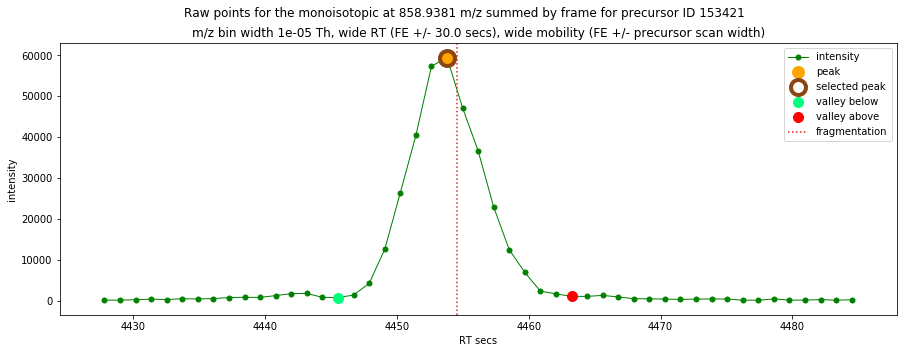

In [167]:
f, ax = plt.subplots()
ax.plot(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='green', linestyle='-', linewidth=1, ms=5)
ax.plot(peaks_df.retention_time_secs, peaks_df.intensity, marker='o', color='orange', linestyle='', markeredgewidth=3, ms=10, label='peak')
ax.plot(peaks_df.loc[peak_idx].retention_time_secs, peaks_df.loc[peak_idx].intensity, marker='o', markerfacecolor='none', markeredgecolor='saddlebrown', linestyle='', markeredgewidth=4, ms=15, label='selected peak')
if valley_idx_below != -1:
    ax.plot(valleys_df.loc[valley_idx_below].retention_time_secs, valleys_df.loc[valley_idx_below].intensity, marker='o', color='springgreen', linestyle='', markeredgewidth=1, ms=10, label='valley below')
if valley_idx_above != -1:
    ax.plot(valleys_df.loc[valley_idx_above].retention_time_secs, valleys_df.loc[valley_idx_above].intensity, marker='o', color='red', linestyle='', markeredgewidth=1, ms=10, label='valley above')
plt.axvline(x=window_df.retention_time_secs, linestyle=':', color='tab:red', label='fragmentation')
plt.legend(loc='best')
plt.xlabel('RT secs')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points for the monoisotopic at {:.4f} m/z summed by frame for precursor ID {}'.format(feature_monoisotopic_mz, precursor_id))
plt.title('m/z bin width {} Th, wide RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()

### Having extracted the MS1 feature characteristics, find all isolation windows that overlap with it

In [168]:
feature_monoisotopic_mz, feature_rt_apex, feature_rt_base_lower, feature_rt_base_upper, feature_scan_centroid, feature_scan_lower, feature_scan_upper

(858.938084065498,
 4453.805803394633,
 4445.5430400577025,
 4463.244901890858,
 462.40349209355173,
 462.0,
 487.0)

In [169]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [170]:
# add-in the retention time for the isolation windows and filter out the windows not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])

In [171]:
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2)
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2)

In [172]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
312803,40408,112,137,1135.738520,3.000000,147429,4340.019894,1134.238520,1137.238520
312804,40408,181,206,994.022363,3.000000,147430,4340.019894,992.522363,995.522363
312805,40408,263,288,1054.650881,3.000000,147451,4340.019894,1053.150881,1056.150881
312806,40408,324,349,789.368380,2.893684,147452,4340.019894,787.921538,790.815222
312807,40408,368,393,826.901660,3.000000,147453,4340.019894,825.401660,828.401660


In [173]:
# define the visualisation window
visualisation_mz_upper = feature_monoisotopic_mz + 3
visualisation_mz_lower = feature_monoisotopic_mz - 3
visualisation_scan_upper = feature_scan_upper + 20
visualisation_scan_lower = feature_scan_lower - 20
visualisation_rt_upper = feature_rt_base_upper
visualisation_rt_lower = feature_rt_base_lower

In [174]:
# find the isolation windows visible in the visualisation window
indexes = isolation_window_df.index[
                        (
                            ((isolation_window_df.mz_lower >= visualisation_mz_lower) &
                             (isolation_window_df.mz_lower <= visualisation_mz_upper)) |
                            ((isolation_window_df.mz_upper >= visualisation_mz_lower) &
                            (isolation_window_df.mz_upper <= visualisation_mz_upper))
                        ) &
                        (
                            ((isolation_window_df.ScanNumBegin >= visualisation_scan_lower) &
                             (isolation_window_df.ScanNumBegin <= visualisation_scan_upper)) |
                            ((isolation_window_df.ScanNumEnd >= visualisation_scan_lower) &
                            (isolation_window_df.ScanNumEnd <= visualisation_scan_upper))
                        ) &
                        (isolation_window_df.retention_time_secs >= visualisation_rt_lower) &
                        (isolation_window_df.retention_time_secs <= visualisation_rt_upper)
                       ]
isolation_windows_in_visualisation_area_df = isolation_window_df.loc[indexes]

In [175]:
isolation_windows_in_visualisation_area_df

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
323591,41426,429,454,859.431517,3.0,153135,4449.405822,857.931517,860.931517
323603,41427,429,454,859.431517,3.0,153135,4449.513830,857.931517,860.931517
323757,41441,431,456,859.436098,3.0,153221,4451.018196,857.936098,860.936098
324135,41474,462,487,860.444362,3.0,153421,4454.557286,858.944362,861.944362


In [176]:
feature_monoisotopic_mz

858.938084065498

In [177]:
feature_rt_base_lower, feature_rt_base_upper

(4445.5430400577025, 4463.244901890858)

In [178]:
feature_scan_centroid

462.40349209355173

In [179]:
# find the isolation windows overlapping the feature's mono or second peak, plus scan and RT
indexes = isolation_window_df.index[
                            (((isolation_window_df.mz_upper >= feature_monoisotopic_mz) & (isolation_window_df.mz_lower <= feature_monoisotopic_mz)) |
                            ((isolation_window_df.mz_upper >= second_peak_mz) & (isolation_window_df.mz_lower <= second_peak_mz))) &
                            (isolation_window_df.ScanNumEnd >= feature_scan_centroid) &
                            (isolation_window_df.ScanNumBegin <= feature_scan_centroid) &
                            (isolation_window_df.retention_time_secs >= feature_rt_base_lower) &
                            (isolation_window_df.retention_time_secs <= feature_rt_base_upper)
                       ]
isolation_windows_overlapping_feature_df = isolation_window_df.loc[indexes]

In [180]:
isolation_windows_overlapping_feature_df

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
324135,41474,462,487,860.444362,3.0,153421,4454.557286,858.944362,861.944362


In [181]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

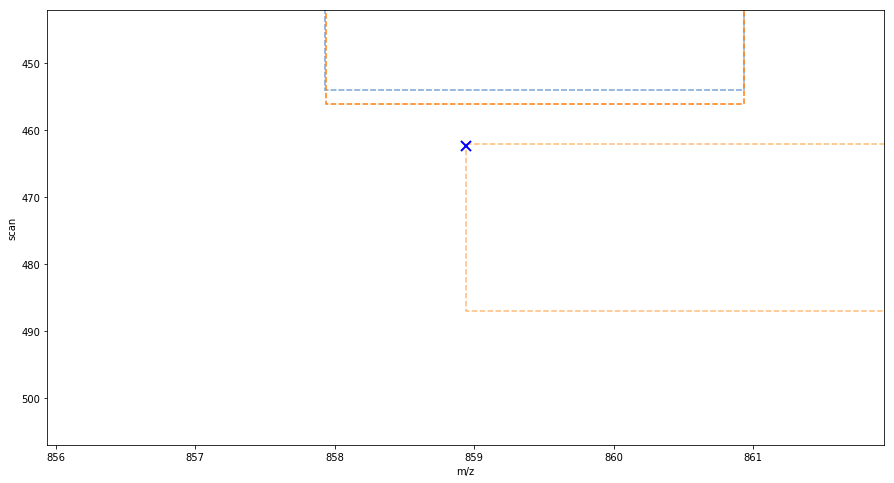

In [182]:
import matplotlib.patches as patches

f, ax1 = plt.subplots()

# add the mono peak's centroid
plt.plot(feature_monoisotopic_mz, feature_scan_centroid, 'bx', ms=10, mew=2, label='centroid')

# add isolation windows matched
for idx in range(len(isolation_windows_in_visualisation_area_df)):
    window = isolation_windows_in_visualisation_area_df.iloc[idx]
    drift_range = window.ScanNumEnd - window.ScanNumBegin
    mz_range = window.mz_upper - window.mz_lower
    isolation_window_rect = patches.Rectangle((window.mz_lower,window.ScanNumBegin),mz_range,drift_range,linewidth=1.5,linestyle='--',edgecolor=tableau20[idx%len(tableau20)],facecolor='none')
    ax1.add_patch(isolation_window_rect)
    text_style = dict(size=12, color=tableau20[idx%len(tableau20)])
#     ax1.text(window.mz_lower, window.ScanNumBegin-0.5, window.frame_precursor, **text_style)
    
f.set_figheight(8)
f.set_figwidth(15)
# plt.gca().invert_yaxis()
plt.gca().set_xlim([visualisation_mz_lower,visualisation_mz_upper])
plt.gca().set_ylim([visualisation_scan_upper,visualisation_scan_lower])
plt.xlabel('m/z')
plt.ylabel('scan')
# plt.legend(loc='best')
plt.margins(0.02)
# plt.suptitle("Feature {} and isolation window overlap, RT={} to {}".format(feature_id_of_interest, round(feature.feature_start_rt,1), round(feature.feature_end_rt,1)))
# plt.title('{}'.format(feature_list_filename))
plt.show()

### Extract all the raw ms2 points from the overlapping isolation windows

In [183]:
# get the ms2 frame IDs
ms2_frame_ids = tuple(ms2_frame_properties_df.astype(int).values[:,0])


In [226]:
ms2_frame_properties_df[ms2_frame_properties_df.frame_id == 41474]

,frame_id,retention_time_secs
969,41474,4454.557286


In [184]:
isolation_window_scan_lower = int(isolation_windows_overlapping_feature_df.iloc[0].ScanNumBegin)
isolation_window_scan_upper = int(isolation_windows_overlapping_feature_df.iloc[0].ScanNumEnd)
isolation_window_frame_id = int(isolation_windows_overlapping_feature_df.iloc[0].Frame)

In [185]:
isolation_window_scan_lower, isolation_window_scan_upper, isolation_window_frame_id

(462, 487, 41474)

In [319]:
# get the raw ms2 points from the fragmentation frame within the scan constraints
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms2_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_id == {} and scan >= {} and scan <= {}".format(isolation_window_frame_id,isolation_window_scan_lower,isolation_window_scan_upper), db_conn)
db_conn.close()

In [320]:
len(ms2_raw_points_df)

1540

In [321]:
MS2_MZ_MAX = ms2_raw_points_df.mz.max()
MS2_MZ_MIN = ms2_raw_points_df.mz.min()

In [322]:
MS2_MZ_MIN, MS2_MZ_MAX

(154.84300242408736, 1648.85541796288)

In [323]:
MS2_MZ_BIN_WIDTH = 1e-5

In [324]:
ms2_bins = np.arange(start=MS2_MZ_MIN, stop=MS2_MZ_MAX+MS2_MZ_BIN_WIDTH, step=MS2_MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [325]:
MS2_MZ_BIN_COUNT = len(ms2_bins)

In [326]:
MS2_MZ_BIN_COUNT

149401243

In [327]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
ms2_mz_values_array = np.empty(MS2_MZ_BIN_COUNT, dtype=np.object)
for idx in range(MS2_MZ_BIN_COUNT):
    ms2_mz_values_array[idx] = []


In [328]:
%%time

# gather the m/z values into bins
for r in zip(ms2_raw_points_df.mz, ms2_raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= MS2_MZ_MIN) and (mz <= MS2_MZ_MAX): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, ms2_bins)) # in which bin should this mz go
        ms2_mz_values_array[mz_array_idx].append((mz, intensity))

CPU times: user 3min 34s, sys: 3.9 s, total: 3min 38s
Wall time: 3min 50s


In [329]:
%%time

# compute the intensity-weighted m/z centroid and the summed intensity of the bins
binned_ms2_l = []
for bin_idx in range(MS2_MZ_BIN_COUNT):
    if len(ms2_mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in ms2_mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in ms2_mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        binned_ms2_l.append((mz_centroid,summed_intensity))

CPU times: user 41.9 s, sys: 15.7 s, total: 57.6 s
Wall time: 1min 12s


In [330]:
len(binned_ms2_l)

1184

In [331]:
binned_ms2_df = pd.DataFrame(binned_ms2_l, columns=['mz_centroid','summed_intensity'])

now do intensity descent to find the peaks

In [332]:
raw_scratch_df = binned_ms2_df.copy() # take a copy because we're going to delete stuff

In [333]:
len(raw_scratch_df)

1184

In [334]:
MZ_DELTA = 0.01

In [335]:
ms2_peaks_l = []
while len(raw_scratch_df) > 0:
    # find the most intense point
    peak_df = raw_scratch_df.loc[raw_scratch_df.summed_intensity.idxmax()]
    peak_mz = peak_df.mz_centroid
    peak_mz_lower = peak_mz - MZ_DELTA
    peak_mz_upper = peak_mz + MZ_DELTA

    # get all the raw points within this m/z region
    peak_raw_points_df = raw_scratch_df[(raw_scratch_df.mz_centroid >= peak_mz_lower) & (raw_scratch_df.mz_centroid <= peak_mz_upper)]
    mz_centroid = peakutils.centroid(peak_raw_points_df.mz_centroid, peak_raw_points_df.summed_intensity)
    summed_intensity = peak_raw_points_df.summed_intensity.sum()
    ms2_peaks_l.append((mz_centroid, summed_intensity))

    # remove the raw points assigned to this peak
    raw_scratch_df = raw_scratch_df[~raw_scratch_df.isin(peak_raw_points_df)].dropna(how = 'all')

In [336]:
ms2_peaks_df = pd.DataFrame(ms2_peaks_l, columns=['mz','intensity'])

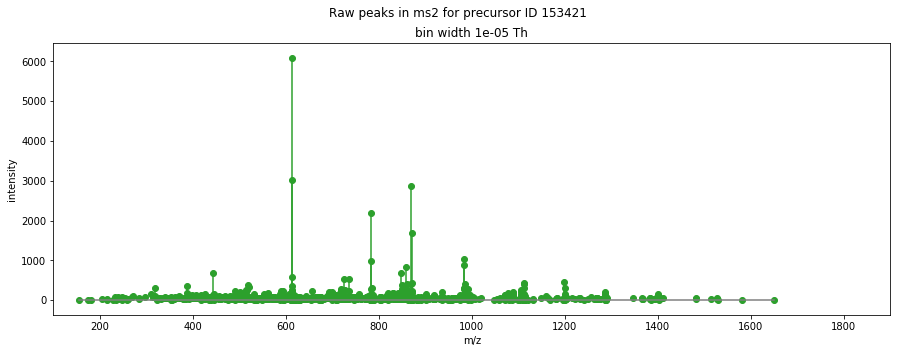

In [337]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(ms2_peaks_df.mz, ms2_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
ax.set_xlim((100,1900))
plt.margins(0.06)
plt.suptitle('Raw peaks in ms2 for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MS2_MZ_BIN_WIDTH))
plt.show()

In [338]:
%%time

# ms2_deconvoluted_peaks, _ = deconvolute_peaks(ms2_peaks, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)
ms2_deconvoluted_peaks, _ = deconvolute_peaks(ms2_peaks_l, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

CPU times: user 556 ms, sys: 67.1 ms, total: 623 ms
Wall time: 635 ms


In [339]:
ms2_peaks_l = []
for peak in ms2_deconvoluted_peaks:
    # discard a monoisotopic peak that has a second isotope with intensity of 1 (rubbish value)
    if ((len(peak.envelope) > 1) and (peak.envelope[1][1] > 1)):
        ms2_peaks_l.append((peak.mz, peak.charge, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise))
        print("{}\n".format(peak))

ms2_deconvoluted_peaks_df = pd.DataFrame(ms2_peaks_l, columns=['mz','charge','neutral_mass','intensity','score','SN'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
ms2_deconvoluted_peaks_df['m_plus_h'] = ms2_deconvoluted_peaks_df.neutral_mass + PROTON_MASS


DeconvolutedPeak(a_to_a2_ratio=0.0, area=434.0, average_mass=317.6739006769863, charge=1, chosen_for_msms=False, envelope=[(318.1818, 315.00), (319.1806, 119.00)], full_width_at_half_max=0.01, index=1|1, intensity=434.0, most_abundant_mass=317.1744823999862, mz=318.1817588667562, neutral_mass=317.1744823999862, score=20.483664404011243, signal_to_noise=217.0)

DeconvolutedPeak(a_to_a2_ratio=0.0, area=539.0, average_mass=386.69763017763495, charge=1, chosen_for_msms=False, envelope=[(387.2005, 367.00), (388.2093, 172.00)], full_width_at_half_max=0.01, index=2|2, intensity=539.0, most_abundant_mass=386.19324179781336, mz=387.20051826458337, neutral_mass=386.19324179781336, score=21.53819871600001, signal_to_noise=269.5)

DeconvolutedPeak(a_to_a2_ratio=0.0, area=134.0, average_mass=398.68121198954657, charge=1, chosen_for_msms=False, envelope=[(399.1888, 86.00), (400.1881, 48.00)], full_width_at_half_max=0.01, index=3|3, intensity=134.0, most_abundant_mass=398.18156340156605, mz=399.18883

In [340]:
len(ms2_deconvoluted_peaks_df)

101

In [341]:
ms2_deconvoluted_peaks_df.mz.min(),ms2_deconvoluted_peaks_df.mz.max()

(318.1817588667562, 1285.653404225305)

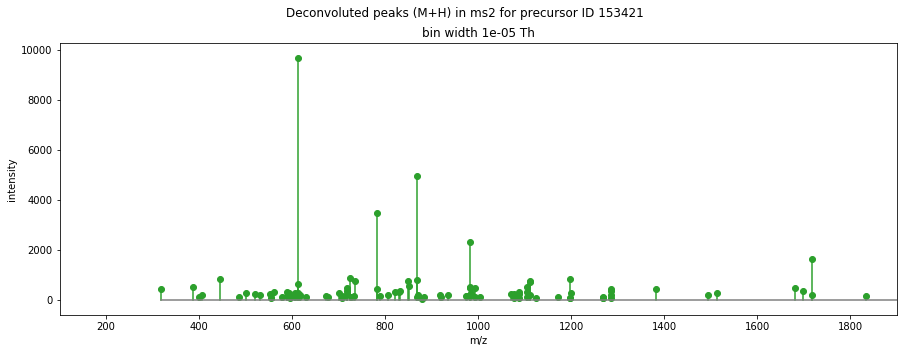

In [342]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(ms2_deconvoluted_peaks_df.m_plus_h, ms2_deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
ax.set_xlim((100,1900))
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks (M+H) in ms2 for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MS2_MZ_BIN_WIDTH))
plt.show()

In [343]:
ms2_deconvoluted_peaks_df[['mz','intensity']].to_csv('/Users/darylwilding-mcbride/Downloads/my_ms2_for_precursor_{}.csv'.format(precursor_id))

In [344]:
# find the top peaks by intensity
ms2_deconvoluted_peaks_df.sort_values(by=['intensity'], ascending=False).head(10)

,mz,charge,neutral_mass,intensity,score,SN,m_plus_h
21,612.308538,1,611.301262,9708.0,125.495360,3236.000000,612.308562
49,869.446607,1,868.439330,4981.0,98.634504,1660.333333,869.446630
39,782.415926,1,781.408649,3495.0,87.079139,1165.000000,782.415949
60,982.527374,1,981.520098,2320.0,50.006763,773.333333,982.527398
97,859.432131,2,1716.849709,1630.0,45.899680,407.500000,1717.857009
35,725.392326,1,724.385049,885.0,39.132952,295.000000,725.392349
82,1198.609736,1,1197.602459,860.0,43.417906,286.666667,1198.609759
4,444.218412,1,443.211136,847.0,33.938719,423.500000,444.218436
50,869.456726,1,868.449450,828.0,29.727459,276.000000,869.456750
46,848.415129,1,847.407852,778.0,18.691312,389.000000,848.415152


### Compare with the ms2 spectra recorded by MaxQuant in the APL files

In [345]:
pasef_msms_scans_df = pd.read_csv(PASEF_MSMS_SCANS_FILENAME, sep='\t')

In [346]:
pasef_msms_scans_df.head()

,Raw file,Frame,Precursor,IsolationMz,IsolationWidth,ScanNumBegin,ScanNumEnd,CollisionEnergy,Index
0,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,1,742.744835,2.427448,507,532,36.96,0
1,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,2,709.235759,2.092358,549,574,36.96,1
2,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,3,594.235088,2.000000,602,627,36.96,2
3,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,4,503.527768,2.000000,643,668,36.96,3
4,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,5,552.063870,2.000000,684,709,31.92,4


In [347]:
pasef_msms_scans_df[pasef_msms_scans_df.Index == 324135]

,Raw file,Frame,Precursor,IsolationMz,IsolationWidth,ScanNumBegin,ScanNumEnd,CollisionEnergy,Index
324135,HeLa_20KInt_2KIT_Slot1-46_01_1179,41474,153421,860.444362,3.0,462,487,42.0,324135


In [348]:
mq_index = pasef_msms_scans_df[pasef_msms_scans_df.Precursor == precursor_id].index.values[0]

In [349]:
mq_index

324135

In [350]:
MIN_ISOTOPE_CORRELATION = 0.9

allpeptides_df = pd.read_csv(ALLPEPTIDES_FILENAME, sep='\t')
allpeptides_df.rename(columns={'Number of isotopic peaks':'isotope_count', 'm/z':'mz', 'Number of data points':'number_data_points', 'Intensity':'intensity', 'Ion mobility index':'scan', 'Ion mobility index length':'scan_length', 'Ion mobility index length (FWHM)':'scan_length_fwhm', 'Retention time':'rt', 'Retention length':'rt_length', 'Retention length (FWHM)':'rt_length_fwhm', 'Charge':'charge_state', 'Number of pasef MS/MS':'number_pasef_ms2_ids', 'Pasef MS/MS IDs':'pasef_msms_ids', 'MS/MS scan number':'msms_scan_number', 'Isotope correlation':'isotope_correlation'}, inplace=True)
# allpeptides_df = allpeptides_df[allpeptides_df.intensity.notnull() & (allpeptides_df.isotope_correlation >= MIN_ISOTOPE_CORRELATION) & (allpeptides_df.rt >= RT_LIMIT_LOWER) & (allpeptides_df.rt <= RT_LIMIT_UPPER)].copy()
allpeptides_df = allpeptides_df[allpeptides_df.intensity.notnull() & allpeptides_df.pasef_msms_ids.notnull() & (allpeptides_df.rt >= RT_LIMIT_LOWER) & (allpeptides_df.rt <= RT_LIMIT_UPPER)].copy()
allpeptides_df.msms_scan_number = allpeptides_df.msms_scan_number.apply(lambda x: int(x))

In [351]:
allpeptides_df.head()

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Min frame index,Max frame index,scan,scan_length,scan_length_fwhm,intensity,Intensities,number_pasef_ms2_ids,pasef_msms_ids,msms_scan_number
636,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,323.16731,644.32008,24772.615335,702,10,2,0.995725,0.320075,...,3851,3860,837,18,18,11378.0,NaN,7,333643;333656;333670;333684;333696;333707;333719,1664
675,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,315.67536,629.33616,24676.000506,738,13,2,0.978703,0.336164,...,3766,3778,849,15,15,8728.3,NaN,14,323932;323944;323992;324006;324019;324033;3240...,1500
1286,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,340.68087,679.34719,24552.706844,1458,12,3,0.998440,0.347187,...,3784,3795,795,27,18,27244.0,NaN,2,325991;326003,2180
1329,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,345.18050,688.34645,24691.651393,1696,16,3,0.997846,0.346450,...,3747,3762,798,27,18,23557.0,NaN,4,321629;321641;321654;321666,2323
1482,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,350.21987,698.42518,24909.307290,3616,21,3,0.999539,0.425184,...,3705,3725,807,30,18,51037.0,NaN,10,316763;316777;316791;316817;316832;316845;3168...,2490


In [352]:
allpeptides_df['pasef_msms_ids_list'] = allpeptides_df.pasef_msms_ids.str.split(";").apply(lambda x: [int(i) for i in x])

In [353]:
allpeptides_df[allpeptides_df.pasef_msms_ids_list.apply(lambda x: 324135 in x)]

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Max frame index,scan,scan_length,scan_length_fwhm,intensity,Intensities,number_pasef_ms2_ids,pasef_msms_ids,msms_scan_number,pasef_msms_ids_list
276594,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,858.93758,1715.8606,24510.713702,13211,19,5,0.999522,0.860598,...,3782,438,108,54,423970.0,NaN,1,324135,66893,[324135]


In [354]:
allpeptides_df[allpeptides_df.pasef_msms_ids_list.apply(lambda x: mq_index in x)]

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Max frame index,scan,scan_length,scan_length_fwhm,intensity,Intensities,number_pasef_ms2_ids,pasef_msms_ids,msms_scan_number,pasef_msms_ids_list
276594,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,858.93758,1715.8606,24510.713702,13211,19,5,0.999522,0.860598,...,3782,438,108,54,423970.0,NaN,1,324135,66893,[324135]


In [355]:
msms_scan_number = int(allpeptides_df[allpeptides_df.pasef_msms_ids_list.apply(lambda x: mq_index in x)].msms_scan_number)

In [356]:
msms_scan_number

66893

In [357]:
# load the ms2 spectra from the APL (hand-pasted into a file for now)
apl_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/allSpectra_5_apl_index_66893.txt', header=None, names=['mz','intensity'], sep='\t')

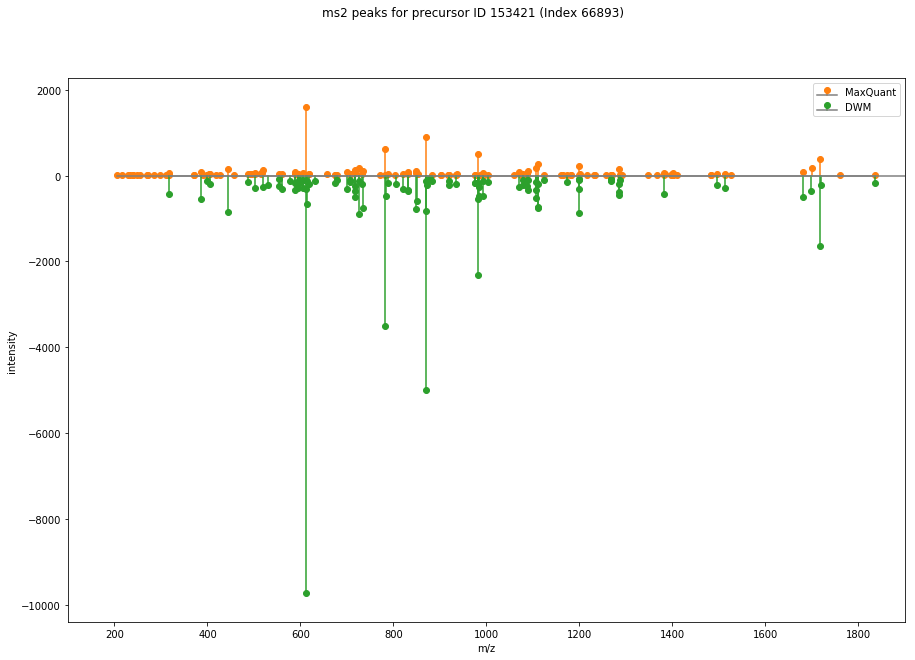

In [358]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(apl_df.mz, apl_df.intensity, 'g', label='MaxQuant')
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])
markerline, stemlines, baseline = ax.stem(ms2_deconvoluted_peaks_df.m_plus_h, -ms2_deconvoluted_peaks_df.intensity, 'g', label='DWM')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(10)
f.set_figwidth(15)
ax.set_xlim((100,1900))
plt.margins(0.06)
plt.legend(loc='best')
plt.suptitle('ms2 peaks for precursor ID {} (Index {})'.format(precursor_id, msms_scan_number))
plt.show()

### Compare with the real identification from MaxQuant

In [ ]:
# check the error from the identification
evidence_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/evidence.txt', sep='\t')